### Essay evaluation app based on 3 criteria: Clarity of thoughts, Depth of Analysis and Language (score between 0-10 for each step) and Final Evaluation with average rating from 3 criteria


In [36]:
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
import operator

In [37]:
load_dotenv()

True

In [38]:
# Schema for structured output from LLM model
class EvaluationSchema(BaseModel):

    feedback: str = Field(description="Short feedback for the essay")
    score: int = Field(description="The score of the essay out of 10", ge=0, le=10)


In [39]:
# define model
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini")

# create model that return response as EvaluationSchema
structured_model = model.with_structured_output(EvaluationSchema)

In [40]:
# define state for workflow
class EvaluationState(TypedDict):

    essay: str

    language_feedback: str
    depth_of_analysis_feedback: str
    clarity_of_thoughts_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[int], operator.add]
    average_score: float


In [41]:
def evaluate_language(state: EvaluationState):

    prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"
    output = structured_model.invoke(prompt)

    return {"language_feedback": output.feedback, "individual_scores": [output.score]}



def evaluate_dept_of_analysis(state: EvaluationState):

    prompt = f"Evaluate the Depth of the analysis of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"
    output = structured_model.invoke(prompt)

    return {"depth_of_analysis_feedback": output.feedback, "individual_scores": [output.score]}



def evaluate_clarity_of_thoughts(state: EvaluationState):

    prompt = f"Evaluate the Clarity of thoughts analysis of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"
    output = structured_model.invoke(prompt)

    return {"clarity_of_thoughts_feedback": output.feedback, "individual_scores": [output.score]}



def final_evaluation(state: EvaluationState):

    # summary feedback
    prompt = f"Based on the following feedback crate a summarized feedback \n Language feedback: {state['language_feedback']} \n Depth of analysis feedback: {state['depth_of_analysis_feedback']} \n Clarity of thoughts feedback: {state['clarity_of_thoughts_feedback']}"

    overall_feedback = model.invoke(prompt).content

    # avg score
    average_score = sum(state["individual_scores"])/len(state["individual_scores"])

    return {"overall_feedback": overall_feedback, "average_score": average_score}


In [42]:
# define graph
graph = StateGraph(EvaluationState)

# define nodes
graph.add_node("evaluate_language", evaluate_language)
graph.add_node("evaluate_dept_of_analysis", evaluate_dept_of_analysis)
graph.add_node("evaluate_clarity_of_thoughts", evaluate_clarity_of_thoughts)
graph.add_node("final_evaluation", final_evaluation)

# define edges
graph.add_edge(START, "evaluate_language")
graph.add_edge(START, "evaluate_dept_of_analysis")
graph.add_edge(START, "evaluate_clarity_of_thoughts")

graph.add_edge("evaluate_language", "final_evaluation")
graph.add_edge("evaluate_dept_of_analysis", "final_evaluation")
graph.add_edge("evaluate_clarity_of_thoughts", "final_evaluation")

graph.add_edge("final_evaluation", END)

# compile graph
workflow = graph.compile()

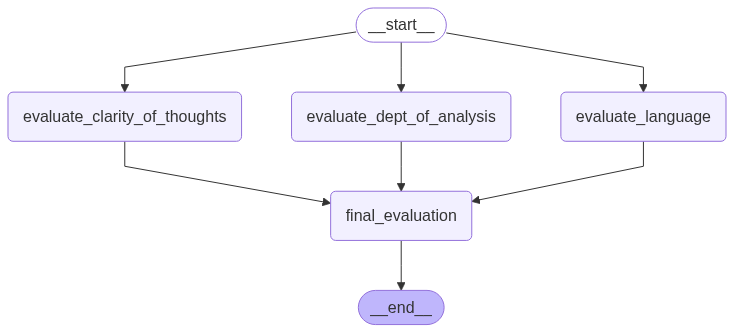

In [43]:
workflow

In [44]:
essay = """
Investing in the Indian economy presents a compelling opportunity due to its robust growth, large and young population, and increasing integration into the global market. While challenges remain, India's strong performance in certain sectors and government initiatives aimed at attracting foreign investment make it an attractive destination for investors seeking long-term growth.
Growth and Opportunity:
India's economy has demonstrated strong growth, particularly in the last decade, with an average annual rate of 6%. This growth is fueled by a large and young population, contributing to a significant consumer base and a growing workforce. Furthermore, India's increasing integration into the global economy, particularly through its services exports, indicates a positive trajectory for future growth.
Key Sectors for Investment:
Several sectors offer promising investment opportunities in India. The technology sector, including startups and tech ventures, has seen significant growth and investment. The manufacturing sector, with initiatives like "Make in India," also presents opportunities for investors looking to capitalize on the country's growing industrial base. Additionally, the infrastructure sector, with government focus on development projects, offers potential for investment in areas like transportation, energy, and urban development.
Challenges and Considerations:
Despite the positive outlook, investors should also be aware of challenges within the Indian economy. Infrastructure deficits, while being addressed, can still pose challenges for businesses. Income inequality and poverty remain concerns, and addressing these issues will be crucial for sustainable and inclusive growth. Furthermore, navigating the complexities of the Indian regulatory and policy landscape requires careful consideration and due diligence.
Government Initiatives:
The Indian government has implemented various initiatives to attract foreign investment and foster a conducive business environment. These include streamlining regulations, reducing corporate taxes, and promoting ease of doing business. These efforts are aimed at creating a more investor-friendly ecosystem and attracting both domestic and foreign capital.
Conclusion:
India's economic landscape presents a mix of opportunities and challenges for investors. While navigating the complexities of the Indian market requires careful consideration, the country's strong growth potential, large and young population, and government initiatives make it a compelling destination for long-term investment. By carefully assessing risks and opportunities, investors can potentially benefit from India's continued economic progress.
"""

In [46]:
initial_state = {"essay": essay}

# execute workflow
output_state = workflow.invoke(initial_state)

In [48]:
for key, value in output_state.items():
    print(f"{key}: {value} \n\n")

essay: 
Investing in the Indian economy presents a compelling opportunity due to its robust growth, large and young population, and increasing integration into the global market. While challenges remain, India's strong performance in certain sectors and government initiatives aimed at attracting foreign investment make it an attractive destination for investors seeking long-term growth. 
Growth and Opportunity:
India's economy has demonstrated strong growth, particularly in the last decade, with an average annual rate of 6%. This growth is fueled by a large and young population, contributing to a significant consumer base and a growing workforce. Furthermore, India's increasing integration into the global economy, particularly through its services exports, indicates a positive trajectory for future growth. 
Key Sectors for Investment:
Several sectors offer promising investment opportunities in India. The technology sector, including startups and tech ventures, has seen significant grow